# Plot timeseries 

Has the system reached equilibrium?

In [31]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FormatStrFormatter
import matplotlib.ticker as mticker
import numpy as np
from datetime import datetime
import nc_time_axis
import cftime
import seaborn as sns
sns.set()
sns.set(rc={"figure.figsize":(10, 7)})
sns.set_style("whitegrid")

# Set up dask

In [7]:
import os
import dask
from dask_jobqueue import PBSCluster
from dask.distributed import Client

USER = os.environ['USER']

/glade/work/gclow/conda-envs/my-npl-ml/lib/python3.7/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [8]:
cluster = PBSCluster(
    cores=1,
    memory='20GB',
    processes=1,
    queue='casper',
    local_directory=f'/glade/scratch/{USER}/dask-workers',
    log_directory=f'/glade/scratch/{USER}/dask-workers',
    resource_spec='select=1:ncpus=1:mem=20GB',
    project='P93300070',
    walltime='03:00:00',
    interface='ib0')

client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/gclow/Batch/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/gclow/Batch/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.54:42800,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/gclow/Batch/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [10]:
cluster.scale(15)

In [42]:
base = '/glade/scratch/gclow/archive/b.e22.B1850.f09_g17.cosp_chlor_30yr/ocn/hist/b.e22.B1850.f09_g17.cosp_chlor_30yr.pop.h.ecosys.nhour1.'

# Pare down the list to just the variables we want to study
varlist = ['totChl']

data = xr.open_mfdataset(base+'*.nc', concat_dim="time", parallel = True, chunks = {'time':120},
                              data_vars='minimal', compat='override', 
                              coords='minimal')

data = data[varlist]

In [4]:
TAREA = xr.open_dataset('/glade/scratch/gclow/archive/b.e22.B1850.f09_g17.cosp_chlor_30yr/ocn/hist/b.e22.B1850.f09_g17.cosp_chlor_30yr.pop.h.nday1.0001-01-01.nc').TAREA

In [43]:
%%time
data_yearly = data.resample(time="AS").mean("time").weighted(TAREA).mean(('nlat', 'nlon')).compute()

CPU times: user 57.6 s, sys: 2.19 s, total: 59.8 s
Wall time: 6min 2s


In [44]:
data_yearly = data_yearly.sel(time=slice('0001-01-01','0049-12-31'))

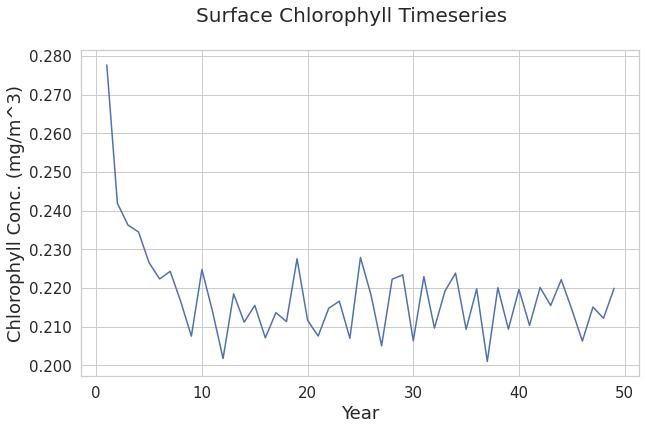

In [46]:
fig, axes = plt.subplots(figsize=(10,6))
fig.suptitle("Surface Chlorophyll Timeseries", fontsize = 20)

ax = sns.lineplot(x = data_yearly.time.dt.year, 
                  y = data_yearly.totChl)

ticks_loc = ax.get_yticks().tolist()
ax.yaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
ax.set_yticklabels(['{:.3f}'.format(x) for x in ticks_loc], size = 15)
ax.set_ylabel("Chlorophyll Conc. (mg/m^3)", fontsize = 18)

ticks_loc = ax.get_xticks().tolist()
ax.xaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
ax.set_xticklabels(['{:.0f}'.format(x) for x in ticks_loc], size = 15)
ax.set_xlabel("Year", fontsize = 18);
plt.savefig('../plots/global_chlor_timeseries.png', bbox_inches = 'tight',pad_inches = 0.3, dpi = 300)

In [47]:
client.close()
cluster.close()